In [1]:
from PIL import Image
import torch
import utils
from torchvision import models
from TCFile import TCFile
import numpy as np

model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\test_5_classes_22.032991_0.9728_sota.pth"
path = r"C:\rkka_Projects\cell_death_v2\Data\9. A549_FasL(20250410)\250409.170229.A549_FasL_01.025.Group4.C5.T025P01.TCF"

# Load Model
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)
model.load_state_dict(torch.load(model_path))
model = model.cuda()

transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
file = TCFile(path, '2DMIP')
center = (385, 464)
a = []
for f in file:
    f = utils.resize_tomogram_mip(f, data_resolution=file.data_resolution, target_resolution=0.1632, mode='mip')
    f = utils.image_normalization(f, min=1.33, max=1.40)
    f = f[center[0]-120:center[0]+120, center[1]-120:center[1]+120]
    
    a.append(f)

a = np.array(a)
a = torch.from_numpy(a)

outputs = []
labels = []
with torch.no_grad():
    model = model.eval()
    for idx, i in enumerate(a):
        i = i.unsqueeze(0).repeat(3,1,1).float()
        i = transform(i)
        output = model(i.unsqueeze(0).cuda())
        outputs.append(output)
        labels.append(int(torch.max(output, 1)[1].cpu().numpy()[0]))

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.nn.functional as F
with torch.no_grad():
    # output = torch.from_numpy(wanted_probabilities[0])
    # Apply softmax to get probabilities
    probabilities = []
    for output in outputs:
        probs = F.softmax(output.cpu(), dim=1)  # shape: [1, 5]
        # If you want it as a simple list or tensor
        probs = probs.squeeze()  # shape: [5]
        probs = probs.numpy()
        probabilities.append(probs)

In [7]:
probs

tensor([[0.0711, 0.8519, 0.0283, 0.0248, 0.0239]])

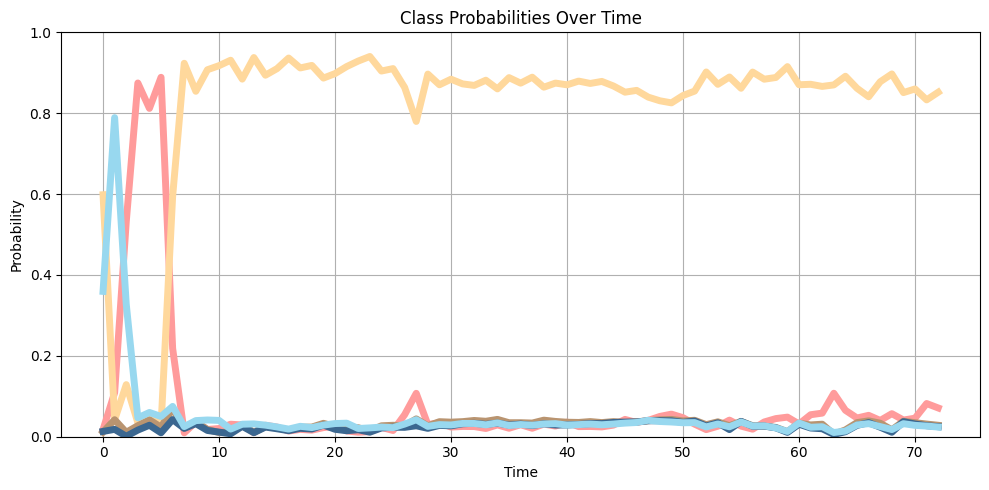

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))

# Example dummy data
class_names = ['Apoptosis', 'Necroptosis', 'Necrosis', 'Control', 'Treated yet Alive']
colors = {1: '#FF9B9B', 2: '#FFD89C', 3: '#B99470', 4: '#3B6790', 5: "#98D8EF"}

for i, class_name in enumerate(class_names):
    color = colors[i + 1]
    plt.plot(np.array(probabilities)[:, i], label=class_name, color=color, linewidth=5)

plt.title("Class Probabilities Over Time")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.ylim(0, 1)
# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import napari
viewer = napari.Viewer()

In [ ]:
file = TCFile(path, '2DMIP')
a = []
for f in file:
    f = utils.resize_tomogram_mip(f, data_resolution=file.data_resolution, target_resolution=0.1632, mode='mip')
    f = utils.image_normalization(f, min=1.33, max=1.40)
    f = f[center[0]-120:center[0]+120, center[1]-120:center[1]+120]
    a.append(f)

a = np.array(a)[20]

viewer.add_image(a)

<Image layer 'a [1]' at 0x1c1c04bd2e0>

In [ ]:
from PIL import Image

file = TCFile(path, '2DMIP')
a = []
for f in file:
    f = utils.resize_tomogram_mip(f, data_resolution=file.data_resolution, target_resolution=0.1632, mode='mip')
    f = utils.image_normalization(f, min=1.33, max=1.40)
    f = f[center[0]-120:center[0]+120, center[1]-120:center[1]+120]
    a.append(f)

a = np.array(a)[8]
image = Image.fromarray(a)
image.save('figures/figure5/cell_c.png')

In [ ]:
probabilities

[array([0.01334382, 0.46900254, 0.0185702 , 0.00949655, 0.48958695],
       dtype=float32)]

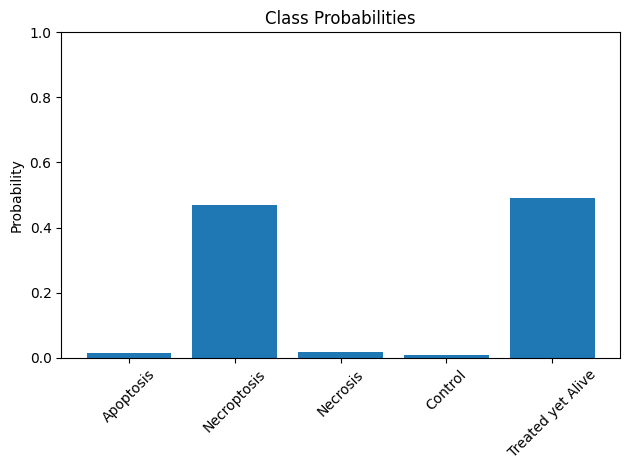

In [ ]:
import matplotlib.pyplot as plt

# Assuming you already have probs as a numpy array
class_names = ['Apoptosis', 'Necroptosis', 'Necrosis', 'Control', 'Treated yet Alive']  # change these to your actual class names

plt.bar(range(len(probs)), probs)
plt.xticks(range(len(probs)), class_names, rotation=45)
plt.ylabel('Probability')
plt.title('Class Probabilities')
plt.tight_layout()
plt.ylim(0,1)
plt.savefig(f'figures/figure5/cell_c_prob.svg', format='svg', transparent=True)
plt.show()